<h1>IMA 205. Challenge Anissa El Idrissi--Feissel</h1>

<h1>I. Introduction</h1>



<h1>II. Import useful libraries</h1>

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib # loading .nii
import scipy.ndimage as ndi
import os
import re
import seaborn as sns

# for random forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

<h1>III. Preprocessing</h1>
<h2>i) Segmentation of the left ventricle</h2>

In our data, the left ventricle is not segmented. Thus, in order to have good results based on accurate features we have to segment it. In order to achieve this, we observe that the left ventricle is always surrounded by the myocardium. We use 

In [90]:
def infer_lv_from_myocardium(seg):
    inferred_lv = np.zeros_like(seg, dtype=np.uint8)

    for z in range(seg.shape[2]):
        slice_seg = seg[:, :, z]
        myocardium = (slice_seg == 2)

        if np.sum(myocardium) == 0:
            continue

        center = ndi.center_of_mass(myocardium)
        if np.isnan(center[0]) or np.isnan(center[1]):
            continue
        center = tuple(map(int, center))

        # Si center tombe en-dehors du myocarde, ça reste OK
        if slice_seg[center] != 0:
            continue  # on skippe ce cas

        mask = (slice_seg == 0)
        filled = ndi.binary_fill_holes(mask)
        labeled, num_features = ndi.label(filled)

        if center[0] < 0 or center[0] >= filled.shape[0] or center[1] < 0 or center[1] >= filled.shape[1]:
            continue  # sécurité

        label_at_center = labeled[center]
        if label_at_center == 0:
            continue

        inferred_lv[:, :, z] = (labeled == label_at_center).astype(np.uint8)

    return inferred_lv


In [99]:
def segmentation_left_vent(seg) :
# Create a copy to avoid modifying the original array in place
    seg_with_lv = seg.copy().astype(np.uint8)

    # Iterate through each slice in the z-dimension
    for z in range(seg_with_lv.shape[2]):
        slice_seg = seg_with_lv[:, :, z]
        myocardium_mask = (slice_seg == 2) # Mask for the myocardium

        # Skip the slice if no myocardium is present
        if np.sum(myocardium_mask) == 0:
            continue

        # Calculate the center of mass of the myocardium in the current slice
        center = ndi.center_of_mass(myocardium_mask)

        # Check if center_of_mass returned NaN (happens if the mask is empty, though checked above)
        if np.isnan(center[0]) or np.isnan(center[1]):
            continue

        # Convert the float coordinates of the center to integers
        center_int = (int(center[0]), int(center[1]))

        # Security check: ensure the calculated center is within the slice boundaries
        if not (0 <= center_int[0] < slice_seg.shape[0] and 0 <= center_int[1] < slice_seg.shape[1]):
             continue

        # If the center of mass falls on an already labeled area (not the cavity=0), skip this slice.
        # We assume the LV cavity is initially part of the unlabeled background (label 0).
        if slice_seg[center_int] != 0:
             continue

        # Create a mask of the potential cavity area (label 0)
        cavity_mask = (slice_seg == 0)

        # Fill holes in the cavity mask. This operation fills enclosed regions of 'True' (cavity).
        # If the myocardium surrounds the LV cavity, filling the holes in the cavity mask
        # should isolate the LV cavity as a filled region.
        filled_cavity = ndi.binary_fill_holes(cavity_mask)

        # Label connected components in the filled cavity mask.
        # This assigns a unique integer label to each distinct filled region.
        labeled_cavity, num_features = ndi.label(filled_cavity)

        # Get the label of the connected component that contains the myocardium's center of mass.
        # This component is likely the LV cavity.
        label_at_center = labeled_cavity[center_int]

        # If the center is not within any labeled component (label_at_center is 0), skip.
        if label_at_center == 0:
            continue

        # Create a mask for the inferred LV cavity based on the identified label
        inferred_lv_mask = (labeled_cavity == label_at_center)

        # Assign label 1 to the pixels identified as the inferred LV cavity
        seg_with_lv[inferred_lv_mask, z] = 1 # LV is label 1

    return seg_with_lv

<h2>ii) Build a dataset</h2> 

In [101]:
train_folder = "Train"

# Define the mapping from class labels to diagnostic classes
class_map = {
    0: "Healthy control",
    1: "Myocardial infarction",
    2: "Dilated cardiomyopathy",
    3: "Hypertrophic cardiomyopathy",
    4: "Abnormal right ventricle"
}

#TRAIN SET
data = {}

# extract metadata
metadata = np.loadtxt(f"metadataTrain.csv", delimiter=",", skiprows=1)
ids = metadata[:, 0].astype(int)
heights = metadata[:, 2]
weights = metadata[:, 3]

for i, id_subject in enumerate(ids):
    # Get the image data and metadata for the current subject
    image_data = {}
    for image_type in ['ED', 'ES']:
        for image_suffix in ['', '_seg']:
            image_path = os.path.join(train_folder, f"{id_subject:03}/{id_subject:03}_{image_type}{image_suffix}.nii")
            image_data[f"{image_type}{image_suffix}"] = nib.load(image_path).get_fdata()
    data[id_subject] = {"image_data": {k: v for k, v in image_data.items() if k in ['ED', 'ES', 'ED_seg', 'ES_seg']},
                        "height": heights[i], "weight": weights[i], 
                        "class": metadata[i-1, 1]}
    
    

In [92]:
def build_dataset_from_folder(root_folder):
    data = []
    # On parcourt seulement les dossiers directs de root_folder
    for entry in sorted(os.scandir(root_folder), key=lambda e: e.name):
        if not entry.is_dir():
            continue

        patient_id = entry.name
        files = os.listdir(entry.path)

        # On cherche tout fichier contenant à la fois "seg" et "ED" (insensible à la casse)
        seg_ed = next((os.path.join(entry.path, f)
                       for f in files
                       if re.search(r"seg.*ed|ed.*seg", f, re.IGNORECASE)), None)
        seg_es = next((os.path.join(entry.path, f)
                       for f in files
                       if re.search(r"seg.*es|es.*seg", f, re.IGNORECASE)), None)

        if not seg_ed or not seg_es:
            print(f"[!] Manquant ED ou ES pour {patient_id}")
            continue

        # Chargement et extraction
        img_ed = nib.load(seg_ed).get_fdata()
        img_es = nib.load(seg_es).get_fdata()
        feats = extract_features_volume_ratios(img_ed, img_es)
        feats["patient_id"] = patient_id
        data.append(feats)

    return pd.DataFrame(data)

#Train data

train_folder_path = "Train"
df = build_dataset_from_folder(train_folder_path)

df.rename(columns={"id": "patient_id"}, inplace=True)
meta_df = pd.read_csv("metaDataTrain.csv")  
meta_df.rename(columns={"Id": "patient_id"}, inplace=True)

meta_df["patient_id"] = meta_df["patient_id"].astype(int).astype(str).str.zfill(3)
df["patient_id"] = df["patient_id"].astype(str)

merged_df = pd.merge(df, meta_df, on="patient_id")

X = merged_df.drop(columns=["patient_id", "Category"])
y = merged_df["Category"]
print(merged_df["Category"].value_counts())

#Test data
test_folder_path = "Test"
df_test = build_dataset_from_folder(test_folder_path)
df_test.rename(columns={"id": "patient_id"}, inplace=True)

meta_test_df = pd.read_csv("metaDataTest.csv")  
meta_test_df.rename(columns={"Id": "patient_id"}, inplace=True)

meta_test_df["patient_id"] = meta_test_df["patient_id"].astype(int).astype(str).str.zfill(3)
df_test["patient_id"] = df_test["patient_id"].astype(str)

merged_test_df = pd.merge(df_test, meta_test_df, on="patient_id")

X_test = merged_test_df.drop(columns=["patient_id"])  


Category
2    20
3    20
1    20
0    20
4    20
Name: count, dtype: int64


<h1>IV. Methods of classification</h1>
<h2> i) Method 1. Naive method</h2>

A random forest with basic features.

First we extract features we wanna try 

<h2> ii) Better method</h2>

In [93]:
def extract_features_volume_ratios(seg_ed, seg_es):
    features = {}

    def volume(mask):
        return np.sum(mask)

    def safe_ratio(a, b):
        return a / b if b != 0 else 0

    # Inference du VG à partir du myocarde si besoin
    if np.sum(seg_ed == 1) == 0:
        seg_ed = seg_ed.copy()
        inferred = infer_lv_from_myocardium(seg_ed)
        seg_ed[inferred == 1] = 1

    if np.sum(seg_es == 1) == 0:
        seg_es = seg_es.copy()
        inferred = infer_lv_from_myocardium(seg_es)
        seg_es[inferred == 1] = 1

    volumes_ed = {
        'LV': volume(seg_ed == 1),
        'Myocardium': volume(seg_ed == 2),
        'RV': volume(seg_ed == 3),
    }
    volumes_es = {
        'LV': volume(seg_es == 1),
        'Myocardium': volume(seg_es == 2),
        'RV': volume(seg_es == 3),
    }

    for k in volumes_ed:
        features[f"{k}_ED"] = volumes_ed[k]
        features[f"{k}_ES"] = volumes_es[k]
        features[f"{k}_EF"] = safe_ratio(volumes_ed[k] - volumes_es[k], volumes_ed[k])

    features["RV_LV_ratio_ED"] = safe_ratio(volumes_ed['RV'], volumes_ed['LV'])
    features["RV_LV_ratio_ES"] = safe_ratio(volumes_es['RV'], volumes_es['LV'])
    features["Myocardium_LV_ratio_ED"] = safe_ratio(volumes_ed['Myocardium'], volumes_ed['LV'])
    features["Myocardium_LV_ratio_ES"] = safe_ratio(volumes_es['Myocardium'], volumes_es['LV'])

    return features

In [100]:
def extract_features_volume_ratios(seg_ed, seg_es):
    features = {}

    # Define the labels and their corresponding anatomical names
    label_map = {
        1: "lv", # Left Ventricle
        2: "myo", # Myocardium
        3: "rv"  # Right Ventricle
    }

    # Helper function to calculate ratio safely (avoids division by zero)
    def safe_ratio(a, b):
        """Calculates ratio a/b, returns 0 if denominator b is zero."""
        return a / b if b != 0 else 0

    # --- Volume Calculations ---
    volumes_ed = {}
    volumes_es = {}
    for label, name in label_map.items():
        # Calculate volume by summing voxels of the specific label and multiplying by voxel volume
        volumes_ed[name] = np.sum(seg_ed == label) * voxel_volume
        volumes_es[name] = np.sum(seg_es == label) * voxel_volume

    # Add calculated volumes to the features dictionary
    for name in label_map.values():
        features[f"{name}_vol_ed"] = volumes_ed[name]
        features[f"{name}_vol_es"] = volumes_es[name]
        # Calculate Ejection Fraction (EF) for each structure (though EF is typically for LV)
        # EF = (End-Diastolic Volume - End-Systolic Volume) / End-Diastolic Volume
        features[f"{name}_ef"] = safe_ratio(volumes_ed[name] - volumes_es[name], volumes_ed[name])

    # --- Volume Ratio Calculations ---
    # Ratios at End-Diastole (ED)
    features["ratio_lv_rv_ed"] = safe_ratio(volumes_ed['lv'], volumes_ed['rv'])
    features["ratio_lv_myo_ed"] = safe_ratio(volumes_ed['lv'], volumes_ed['myo'])
    features["ratio_rv_lv_ed"] = safe_ratio(volumes_ed['rv'], volumes_ed['lv'])
    features["ratio_myo_lv_ed"] = safe_ratio(volumes_ed['myo'], volumes_ed['lv'])

    # Ratios at End-Systole (ES)
    features["ratio_lv_rv_es"] = safe_ratio(volumes_es['lv'], volumes_es['rv'])
    features["ratio_lv_myo_es"] = safe_ratio(volumes_es['lv'], volumes_es['myo'])
    features["ratio_rv_lv_es"] = safe_ratio(volumes_es['rv'], volumes_es['lv'])
    features["ratio_myo_lv_es"] = safe_ratio(volumes_es['myo'], volumes_es['lv'])

    # --- Relative Volume Variation ---
    # This is essentially the same as EF for cavities, but can be applied to myocardium too.
    for name in ["lv", "myo", "rv"]:
        ed_vol = features[f"{name}_vol_ed"]
        es_vol = features[f"{name}_vol_es"]
        features[f"{name}_variation"] = safe_ratio(ed_vol - es_vol, ed_vol)

    # --- Area per Slice Statistics ---
    # Calculate mean and standard deviation of the area for each structure across slices.
    # This gives an idea of the distribution of the structure's size along the z-axis.
    for label, name in label_map.items():
        # ED Area Stats
        mask_ed = seg_ed == label
        # Sum pixels across x and y dimensions for each slice (z)
        # Multiply by voxel area (dx * dy) to get area in physical units
        per_slice_area_ed = np.sum(mask_ed, axis=(0, 1)) * voxel_volume / voxel_dims[2] # Area = Volume / dz (assuming dz is constant)
        features[f"{name}_area_mean_ed"] = np.mean(per_slice_area_ed) if per_slice_area_ed.size > 0 else 0
        features[f"{name}_area_std_ed"] = np.std(per_slice_area_ed) if per_slice_area_ed.size > 0 else 0

        # ES Area Stats
        mask_es = seg_es == label
        per_slice_area_es = np.sum(mask_es, axis=(0, 1)) * voxel_volume / voxel_dims[2]
        features[f"{name}_area_mean_es"] = np.mean(per_slice_area_es) if per_slice_area_es.size > 0 else 0
        features[f"{name}_area_std_es"] = np.std(per_slice_area_es) if per_slice_area_es.size > 0 else 0


    return features

In [94]:
clf = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42)
clf.fit(X, y)

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, cv=skf, scoring="f1_macro")
print("F1 macro CV (5 folds) :", scores.mean())

F1 macro CV (5 folds) : 0.9374603174603175


In [95]:
y_test_pred_2 = clf.predict(X_test)

merged_test_df["Predicted_Category"] = y_test_pred_2

print(merged_test_df[["patient_id", "Predicted_Category"]].head())
y_pred_str = [str(x) for x in y_test_pred_2]
results_df = pd.DataFrame({
    "patient_id": merged_test_df["patient_id"],
    "predicted_group": y_test_pred_2
})

results_df["predicted_group"] = results_df["predicted_group"].astype(str)

results_df.to_csv("predictions_by_patient.csv", index=False)
print("Folder created")



  patient_id  Predicted_Category
0        101                   1
1        102                   4
2        103                   1
3        104                   1
4        105                   2
Folder created


<h2> iii) Third method </h2>

use adaboost

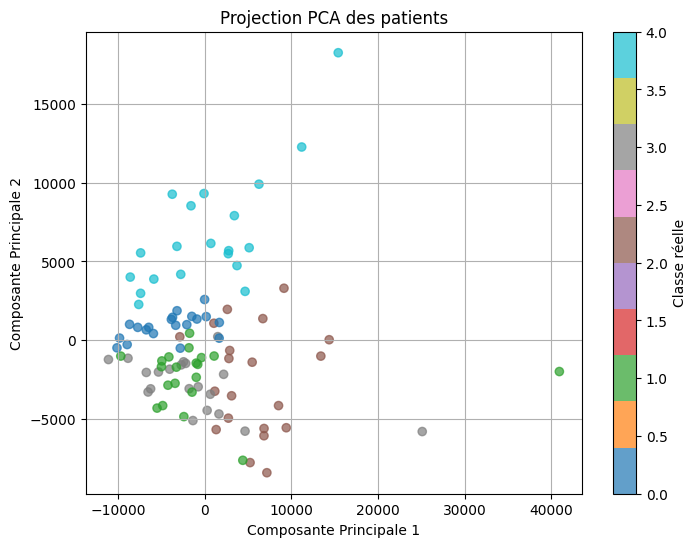

In [96]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Réduction à 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Affichage
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.title("Projection PCA des patients")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.colorbar(scatter, label="Classe réelle")
plt.grid(True)
plt.show()


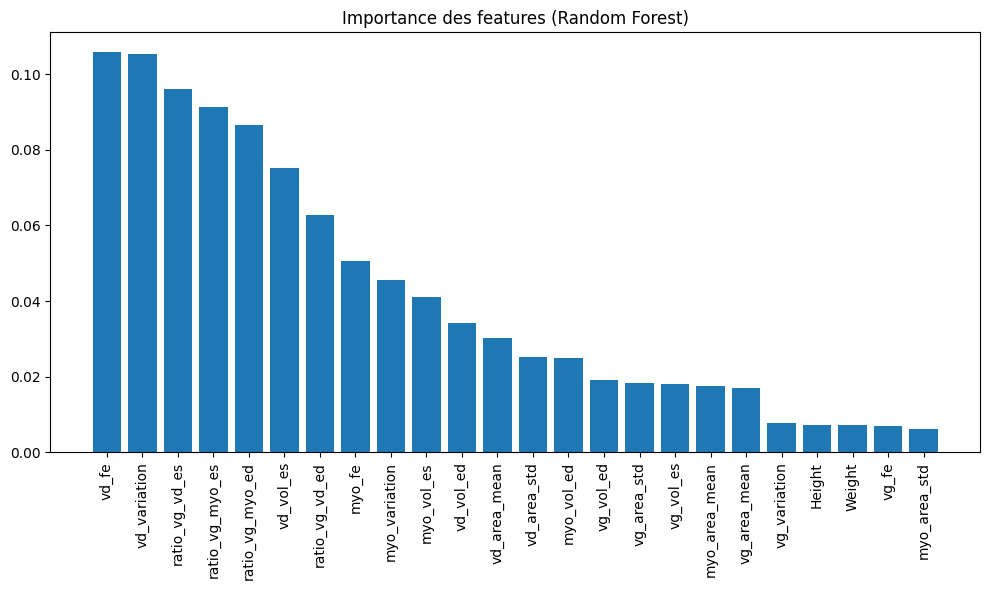

In [97]:
import pandas as pd
import numpy as np

# On entraîne sur tout le jeu pour analyser les features (pas pour évaluer !)
clf.fit(X, y)

importances = clf.feature_importances_
feature_names = X.columns

# Tri décroissant
indices = np.argsort(importances)[::-1]

# Affichage
plt.figure(figsize=(10, 6))
plt.title("Importance des features (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()


In [98]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Matrice de confusion
cm = confusion_matrix(y_val, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

# Affichage
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues')
plt.title("Matrice de Confusion")
plt.show()


# Importance des features
importances = clf.feature_importances_
feature_names = X_train.columns

# Tri et affichage
feat_imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp_df = feat_imp_df.sort_values(by="Importance", ascending=False)

# Affichage graphique
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df["Feature"], feat_imp_df["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.title("Importance des variables")
plt.gca().invert_yaxis()  # Mettre la plus importante en haut
plt.tight_layout()
plt.show()


NameError: name 'y_val' is not defined

In [ ]:
def center_myoc(seg):
    return np.mean(np.argwhere(seg==2), axis=0)

def mask(seg):
    mask_ = np.zeros(seg.shape)
    if (np.argwhere(seg==2).size) ==0 :\
        return mask_
    center= center_myoc(seg)
    dist = np.linalg.norm(np.argwhere(seg==2)-center, axis=1)
    rad = np.max(dist)
    gy, gx = np.mgrid[0:seg.shape[0], 0:seg.shape[1]]
    d = (gx-center[1])**2+(gy-center[0])**2
    mask_[(rad**2<= d) & (d<(rad**2 + 500))] = True
    return mask_

def classifffffy(patient) :
    pat = (patient[0].copy(), patient[1].copy(), patient[2], patient[3])
    for i in range (pat[0].shape[2]) :
        slice_mask_ed = ndi.binary_fill_holes(pat[0][:,:,i]==2)
        seg_ed = 3*(np.int32(slice_mask_ed)-np.int32(pat[0][:,:,i]==2))
        pat[0][:,:,i] +=seg_ed

        slice_mask_es = ndi.binary_fill_holes(pat[1][:,:,i]==2)
        seg_es = 3*(np.int32(slice_mask_es)-np.int32(pat[1][:,:,i]==2))
        pat[1][:,:,i] +=seg_es

        if np.sum(pat[0][:,:,i]==3) == 0 :
            circle = mask(pat[0][:,:,i]) # This should now call the global mask function
            not_full = pat[0][:,:,i] + circle # Corrected indexing
            slice_mask_ed_corrected = ndi.binary_fill_holes(not_full)
            seg_ed_corrected = 3*(np.int32(slice_mask_ed_corrected)-np.int32(not_full))
            pat[0][:,:,i] +=seg_ed_corrected

        if np.sum(pat[1][:,:,i]==3) == 0 :
            circle = mask(pat[1][:,:,i]) # This should now call the global mask function
            not_full = pat[1][:,:,i] + circle # Corrected indexing
            slice_mask_es_corrected = ndi.binary_fill_holes(not_full)
            seg_es_corrected = 3*(np.int32(slice_mask_es_corrected)-np.int32(not_full))
            pat[1][:,:,i] +=seg_es_corrected
    return pat

In [ ]:
def build_X_from_folder(root_folder, metadata_csv=None,test=False):
    X = []
    patient_ids = []

    if metadata_csv is not None:
        metadata = pd.read_csv(metadata_csv)
        metadata = metadata.set_index('Id')

    for entry in sorted(os.scandir(root_folder), key=lambda e: e.name):
        patient_id = entry.name
        patient_folder = entry.path

        try:
            files = os.listdir(patient_folder)
            seg_ed = next(f for f in files if re.search(r"ED.*seg", f, re.I))  # Segment ED (End-Diastolic)
            seg_es = next(f for f in files if re.search(r"ES.*seg", f, re.I))  # Segment ES (End-Systolic)

            path_ed = os.path.join(patient_folder, seg_ed)
            path_es = os.path.join(patient_folder, seg_es)

            img_ed = np.squeeze(tio.ScalarImage(path_ed))
            img_es = np.squeeze(tio.ScalarImage(path_es))

            voxel_dims = nib.load(path_ed).header.get_zooms()[:3]
            voxel_volume = np.prod(voxel_dims)

            if test:
                img_ed_classified, img_es_classified = classify(img_ed), classify(img_es)
            else:
                img_ed_classified, img_es_classified = img_ed, img_es

            features = extract_features(img_ed_classified, img_es_classified, voxel_volume, voxel_dims, patient_id, test)

            feature_values = list(features.values())

            if metadata_csv is not None and patient_id in metadata.index:
                meta = metadata.loc[patient_id]
                meta_values = meta.drop('Category', errors='ignore').values
                feature_values.extend(meta_values)

            X.append(feature_values)
            patient_ids.append(patient_id)

        except Exception as e:
            # Afficher le type d'erreur et le message
            print(f"[!] Erreur lors du traitement du patient {patient_id}: {type(e).__name__} - {e}")
            # Afficher le traceback complet pour savoir où l'erreur s'est produite
            traceback.print_exc()
            print("-" * 20) #

    X = np.array(X)
    return X, patient_ids